A more involved example is a bivariate Jump-Diffusion process, that takes the form
$$\begin{pmatrix}
    \mathrm{d}y_1(t) \\ \mathrm{d}y_2(t)
    \end{pmatrix}=
    \begin{pmatrix}
    N_1 \\ N_2
    \end{pmatrix}
    \mathrm{d} t +
    \begin{pmatrix}
    g_{1,1} & g_{1,2} \\
    g_{2,1} & g_{2,2}
    \end{pmatrix}
    \begin{pmatrix}
    \mathrm{d}W_1 \\ \mathrm{d}W_2
    \end{pmatrix}+
    \begin{pmatrix}
    \xi_{1,1} & \xi_{1,2} \\
    \xi_{2,1} & \xi_{2,2}
    \end{pmatrix}
    \begin{pmatrix}
    \mathrm{d}J_1 \\ \mathrm{d}J_2
    \end{pmatrix}
$$
with $(N_1, N_2)$ the drift vector, $g$ the diffusion matrix, and $\xi$ the jump matrix. The term $(\mathrm{d}W_1(t),\mathrm{d}W_2(t))$ comprises the Brownian motions and $(\mathrm{d}J_1, \mathrm{d}J_2)$ comprises the Poisson jumps.

In [1]:
import numpy as np
xi=np.array([[0.2,0.4,0.6,0.8],[0.3,0.5,0.7,0.9]])
lambd =  np.array([0.2,0.4,0.6,0.8])

t_final = 9000
t_initial = 0
delta_t = 0.001
time = np.arange(t_initial, t_final , delta_t)


In [3]:

X=np.loadtxt('2D_jumpII.dat')

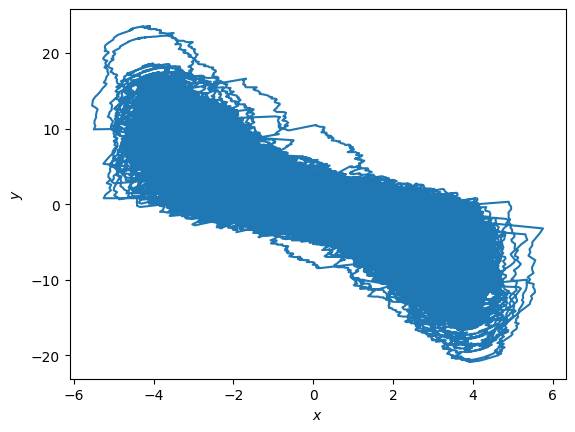

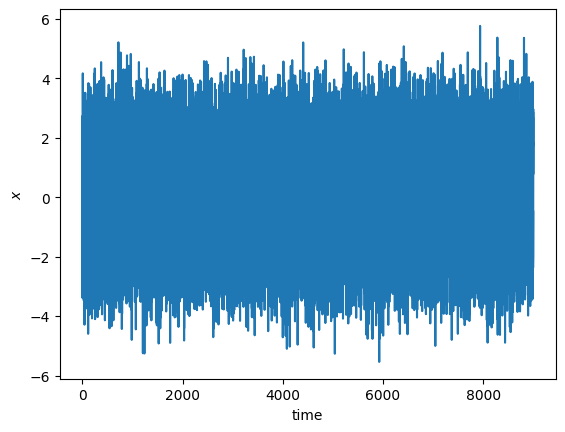

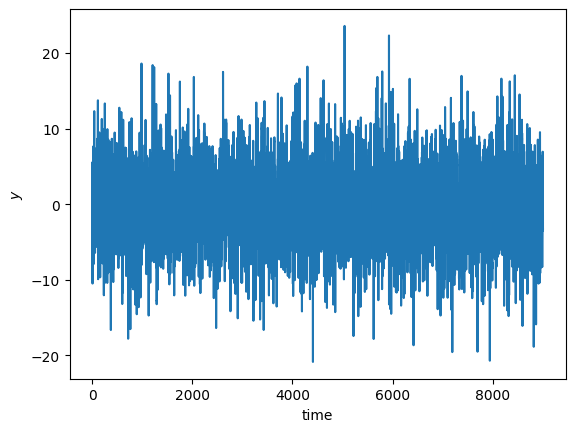

In [4]:
X1=X.T
t_final = 9000
t_initial = 0
delta_t = 0.001
time = np.arange(t_initial, t_final , delta_t)

import matplotlib.pyplot as plt
#This is the stochastic trajectory over time
# %matplotlib auto
%matplotlib inline
plt.figure(2)
plt.plot(X1[:,0], X1[:,1])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
# plt.legend()

plt.figure(3)
plt.plot(time,X1[:,0])
plt.xlabel(r'time')
plt.ylabel(r'$x$')
# plt.legend()


plt.figure(4)
plt.plot(time, X1[:,1])
plt.xlabel(r'time')
plt.ylabel(r'$y$')
# plt.legend()
plt.show(block = True)

In [5]:

from kmc import KM
bins = np.array([2**11,2**11])
powers = np.array([[0,0], [1,0], [0,1], [2,0], [0,2], [4,0], [0,4], [6,0], [0,6]])
moments1,edges1=KM(X1, powers = powers,bins=bins)

In [6]:
delta_t1=0.001
X_11, X_22 = np.meshgrid(edges1[0],edges1[1])
D00=moments1[0,:,:].T/delta_t1
D10=moments1[1,:,:].T/ delta_t1
D01=moments1[2,:,:].T/ delta_t1
D20=moments1[3,:,:].T/ delta_t1
D02=moments1[4,:,:].T/ delta_t1
D40=moments1[5,:,:].T/ delta_t1
D04=moments1[6,:,:].T/ delta_t1
D60=moments1[7,:,:].T/ delta_t1
D06=moments1[8,:,:].T/ delta_t1

In [7]:
tol=1e-5
mask = np.abs(D00) < tol
D00_=D00*~mask
D10_=D10*~mask
D01_=D01*~mask
D20_=D20*~mask
D02_=D02*~mask
D40_=D40*~mask
D04_=D04*~mask
D60_=D60*~mask
D06_=D06*~mask
X_11_=X_11*~mask
X_22_=X_22*~mask



In [8]:

def xydf(X_11_,X_22_):
    a10=X_22_
    a01=X_11_-10*X_22_-3*X_11_**3

    return a10,a01


D10_=D10_[:,:]
a10,_=xydf(X_11_,X_22_)


D01_=D01_[:,:]
_,a01=xydf(X_11_,X_22_)



widths = (edges1[1][1]-edges1[1][0])*(edges1[0][1]-edges1[0][0])
# Compute the area of each bar
areas = D00_ #* widths
# Compute the total area of the histogram
total_area = np.sum(areas)
heights = np.divide(D00, total_area*widths)###sum(heights*widths)=1
heights_=heights*~mask



In [ ]:
maskpdf=(heights>0.00001)
D00__=D00_*maskpdf
D10__=D10_*maskpdf
D01__=D01_*maskpdf

X_11__=X_11_*maskpdf
X_22__=X_22_*maskpdf
a10__=a10*maskpdf
a01__=a01*maskpdf


X_11__[np.isnan(X_11__)] = 0
X_22__[np.isnan(X_22__)] = 0
D10__[np.isnan(D10__)] = 0
D01__[np.isnan(D01__)] = 0



In [11]:
import numpy as np
# from scipy.integrate import odeint
from sklearn.linear_model import Lasso,LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def library(x,librarystyle):
    # x1, x2 = x[:, 0], x[:, 1]
    # return np.transpose([np.ones_like(x1), x1, x2, x1**2, x2**2, x1*x2, np.abs(x1-x2), np.abs(x1+x2)])
    x[np.isnan(x)]=0
    if librarystyle == 'poly_library':
        poly = PolynomialFeatures(degree=3,include_bias=True).fit(x)
        X_poly = poly.fit_transform(x)
        clumns_list = poly.get_feature_names_out()
        Theta=X_poly
        print(clumns_list)
    elif librarystyle == 'fourier_library':
        Theta=np.hstack([np.sin(x),np.cos(x)])
        print('sin(x)','cos(x)')
    elif librarystyle == 'generalized_library':
        poly = PolynomialFeatures(degree=3,include_bias=True).fit(x)
        X_poly = poly.fit_transform(x)
        clumns_list = poly.get_feature_names_out()
        Theta=X_poly
        print(clumns_list,'sin(x)','cos(x)')
        Theta=np.hstack([X_poly, np.sin(x),np.cos(x)])
    
    return Theta

def sparse_regression(X, y):
    model = LinearRegression(fit_intercept=False)
    # model = Lasso(alpha=0.00001, fit_intercept=False, max_iter=100000)
    model.fit(X, y)
    return model.coef_,model.intercept_

def SINDy(X, dx, librarystyle:str,threshold=0.5):
    # pool data & compute library
    dx[np.isnan(dx)]=0
    Theta = library(X,librarystyle)
    for i in range(Theta.shape[1]):
        Xi,intercept_ = sparse_regression(Theta, dx)
        # thresholding
        small_idx = np.abs(Xi) < threshold
        Xi[small_idx] = 0
        Theta[:,small_idx]=0
    return Xi

yn1=D10__.ravel()
yn2=D01__.ravel()

xx1=X_11__.ravel()
xx2=X_22__.ravel()
XX=(np.squeeze(np.array((xx1,xx2)))).T

P11=SINDy(XX,yn1,librarystyle='poly_library')
print(P11)
P21=SINDy(XX,yn2,librarystyle='poly_library')
print(P21)


['1' 'x0' 'x1' 'x0^2' 'x0 x1' 'x1^2' 'x0^3' 'x0^2 x1' 'x0 x1^2' 'x1^3']
[0.         0.         0.98593562 0.         0.         0.
 0.         0.         0.         0.        ]
['1' 'x0' 'x1' 'x0^2' 'x0 x1' 'x1^2' 'x0^3' 'x0^2 x1' 'x0 x1^2' 'x1^3']
[ 0.          1.22913152 -9.92078139  0.          0.          0.
 -2.99292798  0.          0.          0.        ]
